In [12]:
#https://nbviewer.org/github/SHTOOLS/SHTOOLS/blob/master/examples/notebooks/grids-and-coefficients.ipynb
import numpy as np 
import matplotlib.pyplot as plt 
from time import time 

from geomstats.geometry.hypersphere import Hypersphere
import geomstats.visualization as visualization


import functions

def MahaQuantiles(tau,data,MeanData):
    tau = 1 - tau 
    c = np.linspace(0,1,100)
    M = ((data @ MeanData).reshape(len(data),1)-c) 
    M = M*tau - M* (1*(M<=0))
    return( c[np.argmin(np.mean(M,axis=0))] )

def plotMaha(CB_color_cycle,data,el,az,innermost=False):
    MeanData = functions.func_GeomMedian(data)
    rayons = [0.1,0.25,0.5,0.75,0.9]
    plt.figure(figsize=(10,10))
    ax = functions.def_ax_sphere3D(el,az,sph_alpha=0.3)

    functions.plot_3d_scatter(data ,ax,colour="black",sz=1,alpha=0.5)
    
    if innermost==True:
        functions.plot_3d_scatter(MeanData.reshape(1,3) ,ax,colour="red",sz=100,alpha=1)

    for i,tau in enumerate(rayons):
        contourMaha = functions.rotateData(functions.contour_unif( (1+MahaQuantiles(tau,data,MeanData))/2 ) ,MeanData)
        ax.plot(contourMaha[:,0],contourMaha[:,1],contourMaha[:,2],c=CB_color_cycle[i])

def stereoProj(x,m):
    ''' 
    - stereographic projection, x must be of shape (n,3), for n points to compute the stereo projection. n can be equal to 1. 
    - result of same shape as x.
    '''
    scp = (x @ m).reshape(len(x),1)
    return(  (x - scp*m)/(1+scp)  )

def spatialQuantiles(alpha,data,MeanData, N=100):
    ''' returns a quantile contour of level alpha corresponding to spatial quantiles'''
    # contour_unif(0.5) parametrizes the equator, it represents target locations to construct, for each, the estimate (u_n).
    # MeanData is the empirical frechet mean, so u_n is the estimate of a theoretical u depending on a target location z.
    z = functions.rotateData(functions.contour_unif(0.5,size=N),MeanData=MeanData) #rotated so that each element from z is at equidistance from Meandata
    u_n = stereoProj(z,m=MeanData) #for each u_n, we target a quantile Q(alpha*u_n)
    u_n = u_n/np.linalg.norm(u_n,axis=1).reshape(N,1)

    pi_data = stereoProj(data,m=MeanData)
    def loss(pi_mu,alpha,pi_data=pi_data,u_n=u_n):
        ''' takes the stereo proj of mu, returns the loss to be minimized, of same size as u_n '''
        part1 = np.mean(np.linalg.norm(pi_data - pi_mu,axis=1) - np.linalg.norm(pi_data,axis=1))
        part2 = alpha * u_n @ pi_mu
        return(part1 - part2)

    losses = []
    for pi_mu in pi_data:
        losses.append(loss(pi_mu,alpha=alpha))
    losses = np.array(losses) # each loss contains 
    res = data[np.argmin(losses,axis=0)]
    # other code for same purpose ; 
    #res = -np.ones(N) #indexes of minimizers in pi
    #bestLoss = 1000*np.ones(N) # to keep trace of best losses
    #for i,pi_mu in enumerate(pi_data): #along all pi_mu in pi_data, takes the index that minimizes the loss.
    #    L = loss(pi_mu,alpha=alpha)
    #    indic = 1*(L < bestLoss)
    #    bestLoss = L*(indic) + bestLoss*(1-indic)# if loss is better than before, keep it, otherwize do not change 'res'. (this is done for all target locations in u_n at once).
    #   res = i*(indic) + res*(1-indic) # res contains the index of the minimizer mu, for each target location $u_n$ at once.
    ##res = data[res.astype(int)]
    return(res)

def plotSpatial(CB_color_cycle,data,el,az,innermost=False):
    MeanData = functions.func_GeomMedian(data)
    rayons = [0.1,0.25,0.5,0.75,0.9]
    plt.figure(figsize=(10,10))
    ax = functions.def_ax_sphere3D(el,az,sph_alpha=0.3)

    functions.plot_3d_scatter(data ,ax,colour="black",sz=1,alpha=0.5)
    if innermost==True:
        functions.plot_3d_scatter(MeanData.reshape(1,3) ,ax,colour="red",sz=100,alpha=1)

    for i,tau in enumerate(rayons):
        contourSpatial = spatialQuantiles(tau,data=data,MeanData = MeanData)
        ax.plot(contourSpatial[:,0],contourSpatial[:,1],contourSpatial[:,2],c=CB_color_cycle[i])


In [13]:
# 1) sample
n_samples = 2001
#dataA = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0.2,-0.5,np.sqrt(1-0.2**2-0.5**2)]),kappa=50, n_samples=int(n_samples*0.2))
#dataB = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0.2,0.5,np.sqrt(1-0.2**2-0.5**2)]),kappa=50, n_samples=int(n_samples*0.2))
#dataC = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0.7,0,np.sqrt(1-0.7**2)]),kappa=20, n_samples=n_samples-int(n_samples*0.2)*2)
#data = np.concatenate([dataA,dataB,dataC])


# 2) sample 
dataA = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0,-0.5,np.sqrt(0.75)]),kappa=20, n_samples=int(n_samples*0.3))
dataB = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0,0.5,np.sqrt(0.75)]),kappa=20, n_samples=n_samples-int(n_samples*0.3))
data = np.concatenate([dataA,dataB])
data = functions.rotateData(data,np.array([0,-1,0]))

# Tangent elliptical
#m1 = np.array([0,0,1])
#V = np.random.beta(2,8,size=n_samples)
#Z = 2*V -1 
#S = np.zeros((n_samples,3))
#N = np.random.multivariate_normal(mean=np.zeros(2),cov=np.diag([100,1]),size=n_samples)
#N = (N/np.linalg.norm(N,axis=1).reshape((n_samples,1)))
#S[:,0:2] = N
#data = Z.reshape(n_samples,1)*m1 + np.sqrt(1-Z**2).reshape(n_samples,1)*S

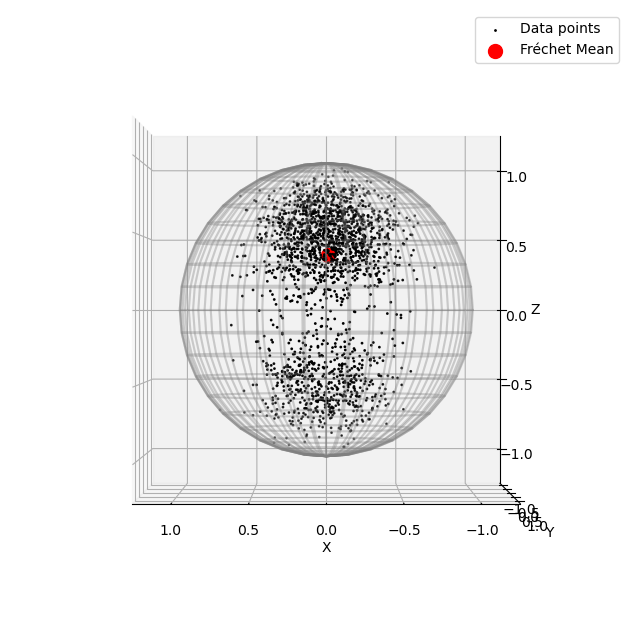

In [14]:
MeanData = functions.func_GeomMedian(data)
fig = plt.figure(figsize=(8, 8))
ax = visualization.plot(data, space="S2", color="black", s=1, label="Data points")
ax = visualization.plot(MeanData.reshape(1,3), space="S2", color="red",alpha=1,s=100, label="Fréchet Mean")
ax.set_box_aspect([1, 1, 1])
ax.legend()
el = 0
az = 90
ax.view_init(el,az)

# Mahalanobis quantiles

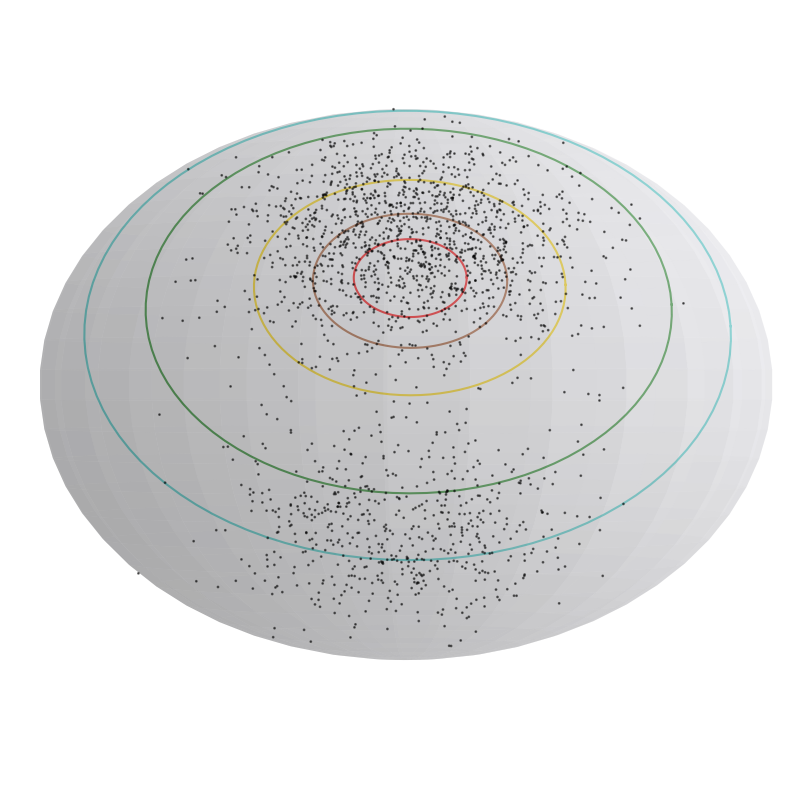

In [15]:
CB_color_cycle = ["red",'#a65628',"gold","forestgreen","mediumturquoise"] #['#e41a1c',  '#a65628', '#4daf4a','#f781bf', '#984ea3','#999999', '#dede00']
plotMaha(CB_color_cycle,data,el=el,az=az)


# Spatial quantiles

Depth contours defined in the paper "Spatial quantiles on the hypersphere" coincide with contours of same quantile level for their definition of quantile function. 

We highlight that these quantile contours are not indexed by their probability content. 



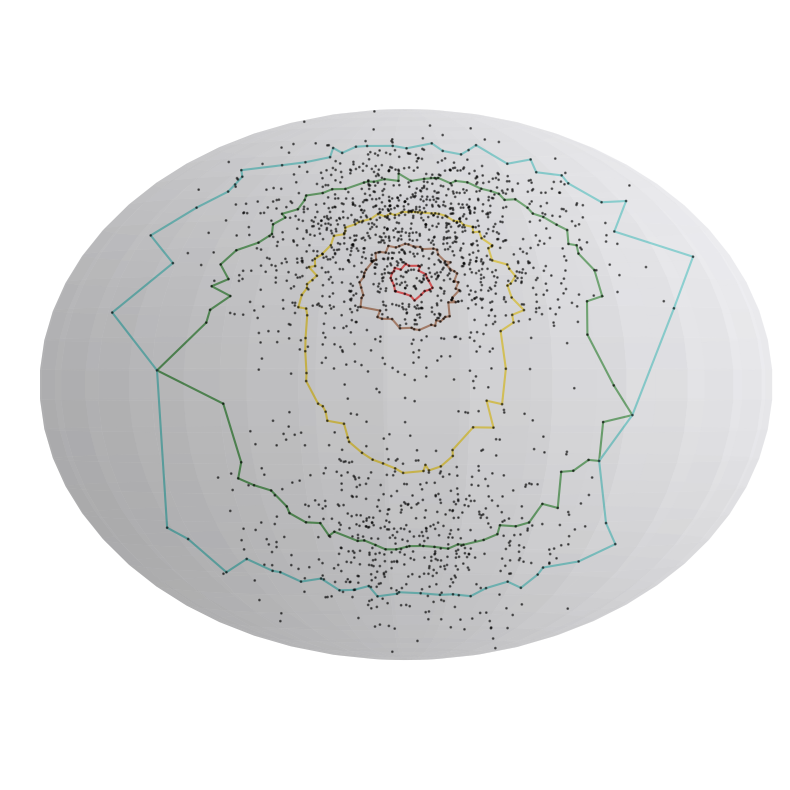

In [5]:
CB_color_cycle = ["red",'#a65628',"gold","forestgreen","mediumturquoise"] #['#e41a1c',  '#a65628', '#4daf4a','#f781bf', '#984ea3','#999999', '#dede00']
plotSpatial(CB_color_cycle,data,el=el,az=az)

# MK quantiles

In [6]:
eps = 0.1

# SGD scheme
t = time()
u,hat_W = functions.Robbins_Monro_Algo(Y=data, eps=eps, gamma= 1, c = 3/4, epoch = 20,l_max=30)
t2 = time()
print("SGD time: {} minutes".format((t2-t)/60))

SGD time: 0.6968001166979472 minutes


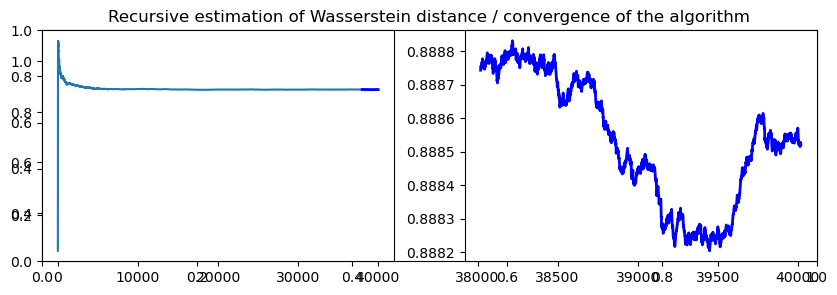

In [8]:
# Check of convergence 1 
epoch = 20
n_iter = len(data)*epoch # len(data)*number of epochs
plt.figure(figsize=(10,3))
plt.title("Recursive estimation of Wasserstein distance / convergence of the algorithm")
plt.subplot(1,2,1)
plt.plot(np.arange(n_iter),hat_W)
n_start = len(data)*(epoch-1)
plt.plot(np.arange(n_start,n_iter),hat_W[n_start:],'b',linewidth=2)

plt.subplot(1,2,2)
plt.plot(np.arange(n_start,n_iter),hat_W[n_start:],'b',linewidth=2)

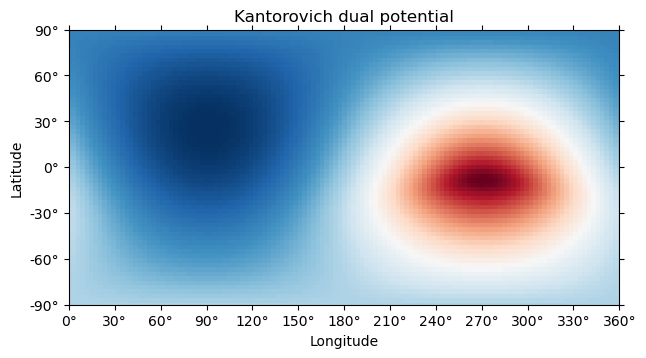

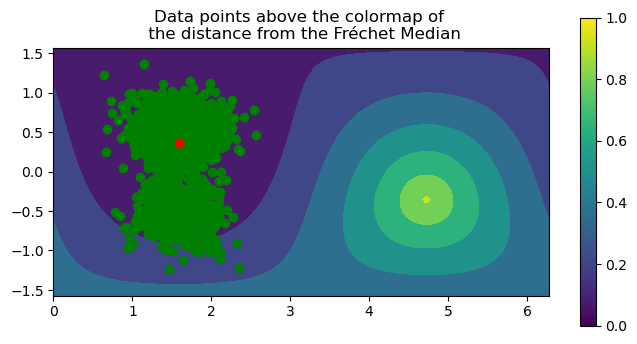

In [9]:
# Check of convergence 2
# 1)
fig, ax = u.plot(cmap='RdBu',
                    cmap_reverse=True,
                    show=False)
plt.title("Kantorovich dual potential")

# 2) 
plt.figure(figsize=(8,4))
v_lat = u.lats()*np.pi/180 #from degrees to radians
v_lon = u.lons()*np.pi/180 
C = functions.cost_fft2(u,MeanData)
h = plt.contourf(v_lon, v_lat, C)
yc = functions.cartesian2polar(data.T)
plt.scatter(yc[0],yc[1],color='green')
yc = functions.cartesian2polar(MeanData)
plt.scatter(yc[0],yc[1],color='red')
plt.axis('scaled')
plt.title("Data points above the colormap of \n the distance from the Fréchet Median")
plt.colorbar()
plt.show()

In [10]:


def plotQcontours(rayons, u,data,eps,el=90,az=45,size=100,dots=False): 
    '''
    - u is the SHgrid object for the fourier serie of the Kantorovich potential
    - rotateddata contains the data oriented to the north pole
    - k is the unit vector for rotating back the data to its original position 
    '''
    ########
    colors = ["red",'#a65628',"gold","forestgreen","mediumturquoise"]*2

    plt.figure(figsize=(10,10))
    ax = functions.def_ax_sphere3D(el,az,sph_alpha=0.3)
    functions.plot_3d_scatter(data ,ax,colour="black",sz=2,alpha=0.5)
    #plot_3d_scatter(MeanData.reshape(1,3) ,ax,colour="red",sz=100,alpha=1)
    MeanData = functions.func_GeomMedian(data) 
    F_thetaM = functions.Fentropic(MeanData,u,eps)
    for i,tau in enumerate(rayons):
        points = functions.contour_unif_rotated(F_thetaM,tau,size=size)
        df = functions.QentropicBP_pts(points,u,data,eps)
        ax.plot(df[:,0],df[:,1],df[:,2],c=colors[i])
        if dots==True:
            ax.scatter(df[:,0],df[:,1],df[:,2],c=colors[i],s=5)

    #for LON in np.linspace(0,2*np.pi,6)[1:]:
    #    df = signcurve_unif_rotated(F_thetaM,LON,size=100)
    #    ax.plot(df[:,0],df[:,1],df[:,2],c="green")

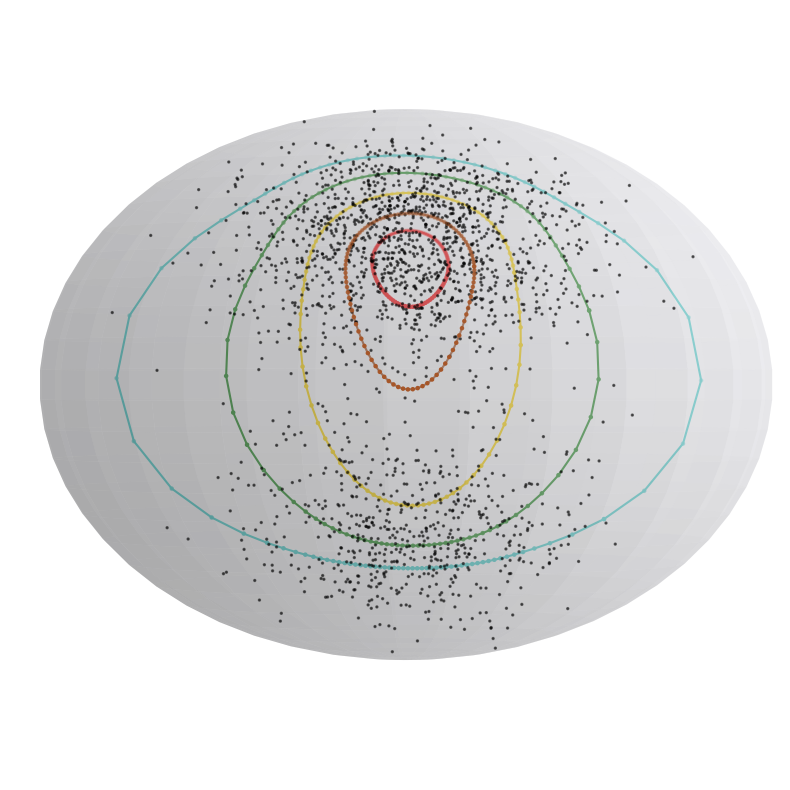

In [11]:
######## PLOTS
rayons = [0.1,0.25,0.5,0.75,0.9]

plotQcontours(rayons, u,data,eps,el=el,az=az,size=100,dots=True)
